In [38]:
import pandas as pd
import numpy as np
import nibabel as nib
import os
import scipy.stats as scp
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
import itertools
from scipy.signal import hilbert
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import scipy.signal as scs
import json
import pickle
import plotly.graph_objects as go
from tqdm.auto import tqdm
from itertools import combinations
import statsmodels.formula.api as smf
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

sns.set(context='talk', style='white', font='Arial')

today = date.today().strftime('%Y%m%d')

project_dir = '/Users/catcamacho/Library/CloudStorage/Box-Box/CCP/HBN_study/'
data_dir = project_dir + 'proc/group/parcel_timeseries/sub_ts/'
out_dir = project_dir + 'proc/clin/'
os.makedirs(out_dir,exist_ok=True)

big_data_dir = '/Users/catcamacho/Documents/bigdata/hbn_clin/'

sample_file = project_dir + 'proc/group/datasets_info/sample_gord.32k_fs_LR.pscalar.nii'
atlas_file = project_dir + 'proc/null_lL_WG33/Gordon333_SeitzmanSubcortical.32k_fs_LR.dlabel.nii'

ax0 = nib.load(sample_file).header.get_axis(0)
ax1 = nib.load(sample_file).header.get_axis(1)

TR = 0.8

# get network labels
parcel_labels = nib.load(sample_file).header.get_axis(1).name
network_labels = []
for s in parcel_labels:
    b = s.split('_')
    if len(b)<2:
        network_labels.append(b[0])
    else:
        network_labels.append(b[1])
network_labels = np.array(network_labels)
network_names, network_sizes = np.unique(network_labels, return_counts=True)

# load subject info
subinfo = pd.read_csv(project_dir + 'proc/group/datasets/firstleveldatalabels_withpub_thresh0.8_20220412.csv', index_col=0)
subinfo = subinfo.drop(['set','sub','cond'], axis=1)
subinfo = subinfo.drop_duplicates()
subinfo.index.name='sub'

scaredsr = pd.read_csv(os.path.join(project_dir, 'phenotypic_data','9994_SCARED_SR_20210322.csv'), index_col='EID', skiprows=[1]).loc[:,'SCARED_SR_SC']
scaredsr.index = ['sub-{0}'.format(a) for a in scaredsr.index]
scaredsr.index.name = 'sub'

scaredpr = pd.read_csv(os.path.join(project_dir, 'phenotypic_data','9994_SCARED_P_20210322.csv'), index_col='EID', skiprows=[1]).loc[:,'SCARED_P_SC']
scaredpr.index = ['sub-{0}'.format(a) for a in scaredpr.index]
scaredpr.index.name = 'sub'

adhd = pd.read_csv(os.path.join(project_dir, 'phenotypic_data','9994_SWAN_20210322.csv'), index_col='EID', skiprows=[1]).loc[:,'SWAN_Avg']
adhd.index = ['sub-{0}'.format(a) for a in adhd.index]
adhd.index.name = 'sub'

subinfo = subinfo.merge(adhd, how='left', left_index=True, right_index=True)
subinfo = subinfo.merge(scaredsr, how='left', left_index=True, right_index=True)
subinfo = subinfo.merge(scaredpr, how='left', left_index=True, right_index=True)

# assign developmental groups
subinfo['age_group'] = 'middle'
subinfo.loc[(subinfo['age']<8),'age_group'] = 'youngest'
subinfo.loc[(subinfo['age']>11), 'age_group'] = 'oldest'

subinfo.loc[np.isfinite(subinfo['PPS_score']),'pub_group'] = 'middle'
subinfo.loc[(subinfo['PPS_score']<=5),'pub_group'] = 'pre'
subinfo.loc[(subinfo['PPS_score']>5) & (subinfo['PPS_score']<=10),'pub_group'] = 'early'
subinfo.loc[(subinfo['PPS_score']>=15), 'pub_group'] = 'late'

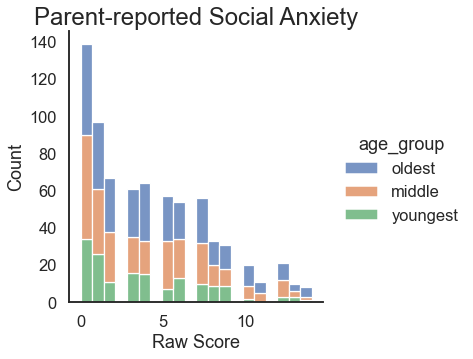

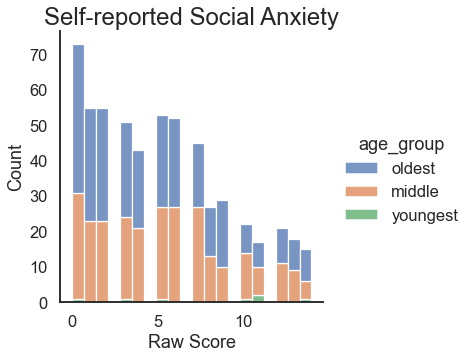

In [39]:
data = subinfo.drop(['meanFD','movie'], axis=1)
data = data.drop_duplicates()
data = data.sort_values('age', ascending=False)
sns.displot(x='SCARED_P_SC', data=data, bins=20, hue='age_group', multiple='stack')
plt.xlabel('Raw Score')
plt.title('Parent-reported Social Anxiety', {'fontsize': 24})
plt.show()
plt.close()
sns.displot(x='SCARED_SR_SC', data=data, bins=20, hue='age_group', multiple='stack')
plt.xlabel('Raw Score')
plt.title('Self-reported Social Anxiety', {'fontsize': 24})
plt.show()
plt.close()

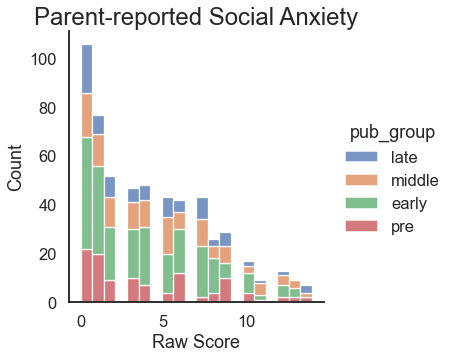

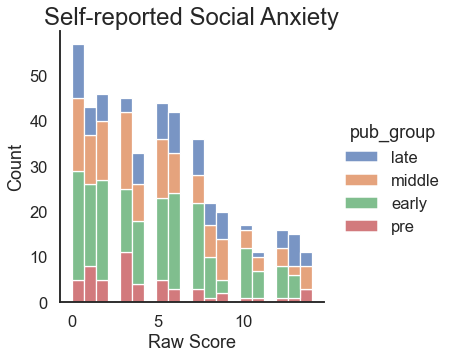

In [40]:
data = subinfo.drop(['meanFD','movie'], axis=1)
data = data.drop_duplicates()
data = data.sort_values('PPS_score', ascending=False)
sns.displot(x='SCARED_P_SC', data=data, bins=20, hue='pub_group', multiple='stack')
plt.xlabel('Raw Score')
plt.title('Parent-reported Social Anxiety', {'fontsize': 24})
plt.show()
plt.close()
sns.displot(x='SCARED_SR_SC', data=data, bins=20, hue='pub_group', multiple='stack')
plt.xlabel('Raw Score')
plt.title('Self-reported Social Anxiety', {'fontsize': 24})
plt.show()
plt.close()

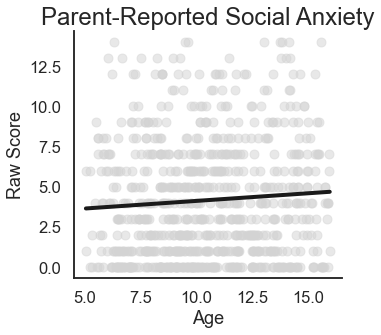

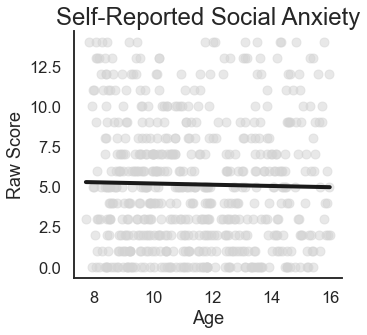

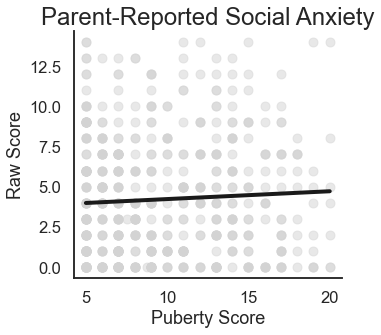

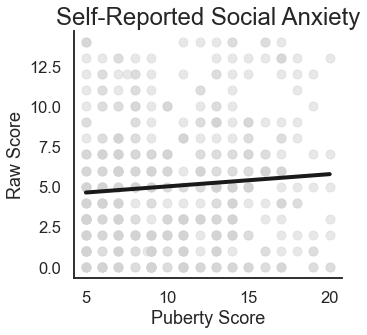

In [37]:
sns.lmplot(x='age',y='SCARED_P_SC', data=data, ci=None, line_kws={'lw':4, 'color':'k'}, 
           scatter_kws={'alpha':0.5, 'color':'lightgray'})
plt.title('Parent-Reported Social Anxiety', {'fontsize': 24})
plt.ylabel('Raw Score')
plt.xlabel('Age')
plt.tight_layout()
plt.show()
plt.close()

sns.lmplot(x='age',y='SCARED_SR_SC', data=data, ci=None, line_kws={'lw':4, 'color':'k'}, 
           scatter_kws={'alpha':0.5, 'color':'lightgray'})
plt.title('Self-Reported Social Anxiety', {'fontsize': 24})
plt.ylabel('Raw Score')
plt.xlabel('Age')
plt.tight_layout()
plt.show()
plt.close()

sns.lmplot(x='PPS_score',y='SCARED_P_SC', data=data, ci=None, line_kws={'lw':4, 'color':'k'}, 
           scatter_kws={'alpha':0.5, 'color':'lightgray'})
plt.title('Parent-Reported Social Anxiety', {'fontsize': 24})
plt.ylabel('Raw Score')
plt.xlabel('Puberty Score')
plt.tight_layout()
plt.show()
plt.close()

sns.lmplot(x='PPS_score',y='SCARED_SR_SC', data=data, ci=None, line_kws={'lw':4, 'color':'k'}, 
           scatter_kws={'alpha':0.5, 'color':'lightgray'})
plt.title('Self-Reported Social Anxiety', {'fontsize': 24})
plt.ylabel('Raw Score')
plt.xlabel('Puberty Score')
plt.tight_layout()
plt.show()
plt.close()